Successfully loaded data from D:/data_for_seg/
Class: keep1, Number of samples: 24
Class: keep0, Number of samples: 21
Class: keep2, Number of samples: 19
Class: dead, Number of samples: 17
Class: empty, Number of samples: 15
Class: split, Number of samples: 12
Class: receed1, Number of samples: 10
Class: receed0, Number of samples: 6


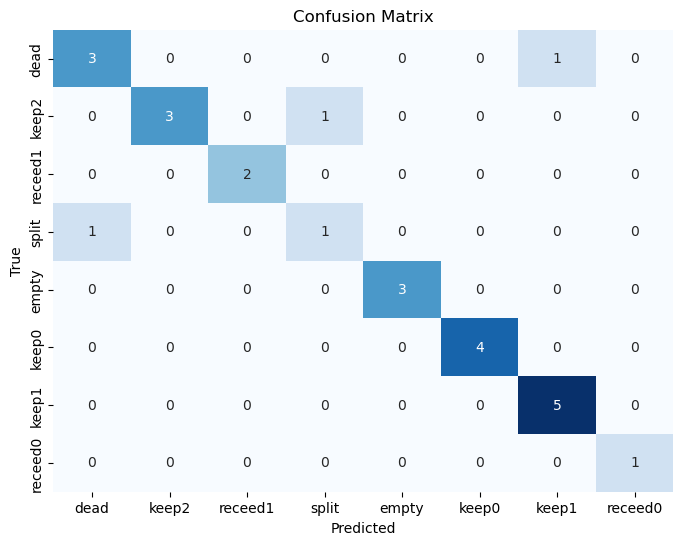

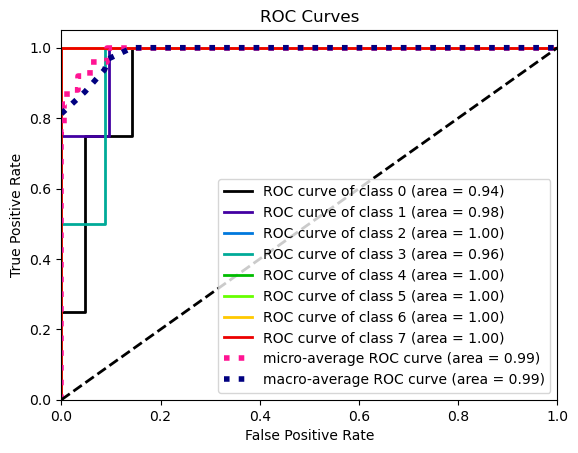

<Figure size 800x600 with 0 Axes>

[6 5 5 6 4 5 2 0 2 1 7 0 3 6 0 1 5 6 6 6 4 3 1 4 0]
Successfully loaded data from D:/data_for_seg/


Successfully loaded data from D:/data_for_seg/


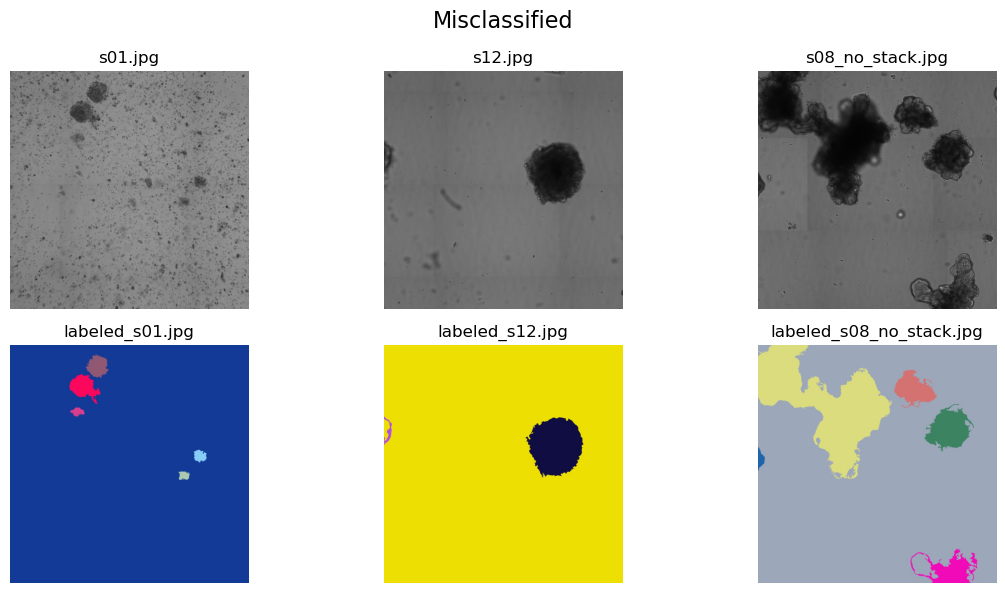

Misclassified Samples (Random State: 30):
14              dead - s01.jpg
54             split - s12.jpg
20    keep2 - s08_no_stack.jpg
dtype: object


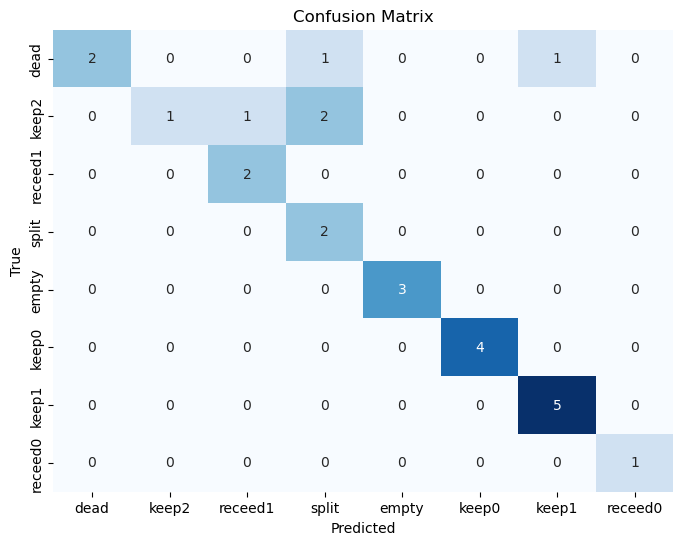

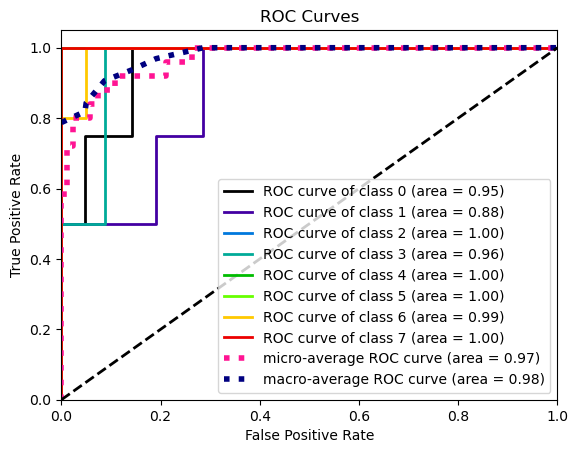

<Figure size 800x600 with 0 Axes>

[4 6 3 5 2 7 2 4 6 3 5 5 6 3 4 2 3 3 1 6 6 6 0 0 5]
Successfully loaded data from D:/data_for_seg/


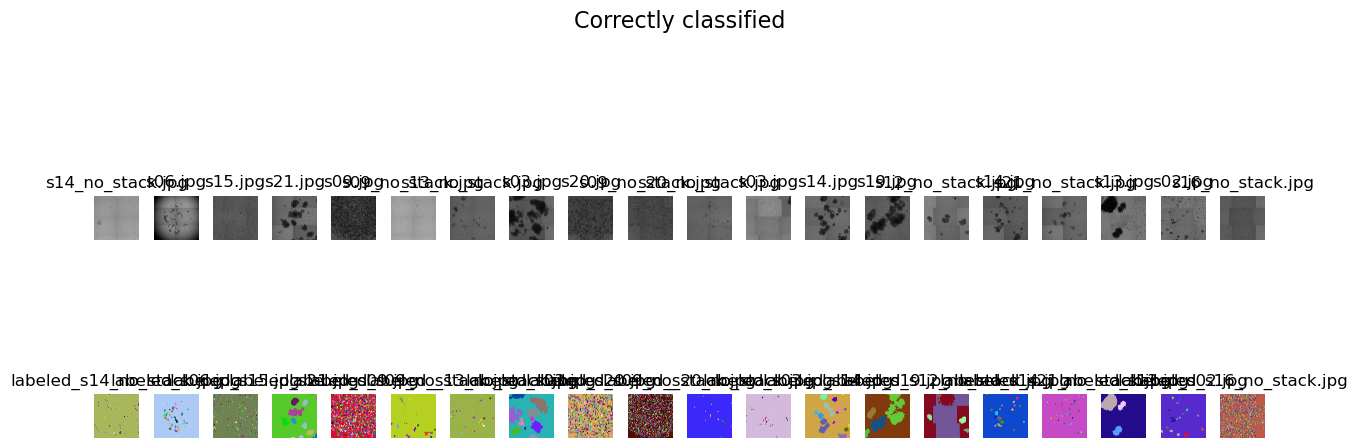

Successfully loaded data from D:/data_for_seg/


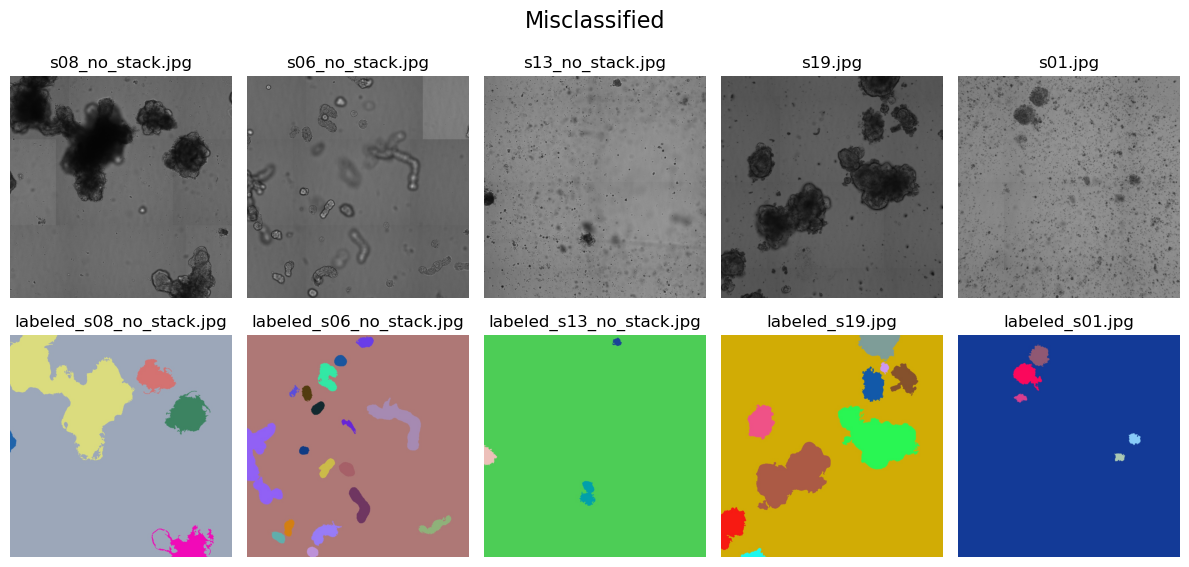

Misclassified Samples (Random State: 25):
20    keep2 - s08_no_stack.jpg
18    keep2 - s06_no_stack.jpg
13     dead - s13_no_stack.jpg
35             keep2 - s19.jpg
14              dead - s01.jpg
dtype: object


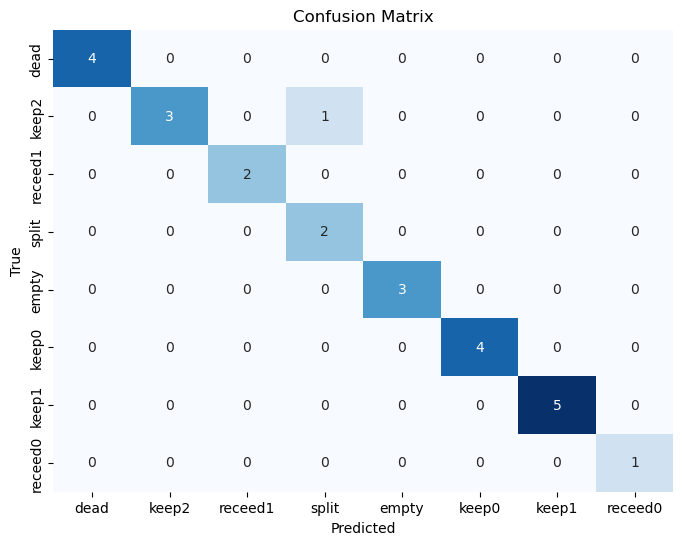

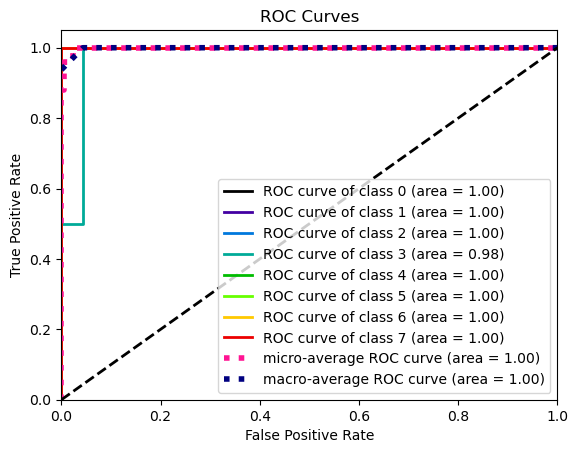

<Figure size 800x600 with 0 Axes>

[5 5 6 5 1 0 1 6 3 4 3 4 2 2 0 4 6 0 3 6 6 5 1 0 7]
Successfully loaded data from D:/data_for_seg/


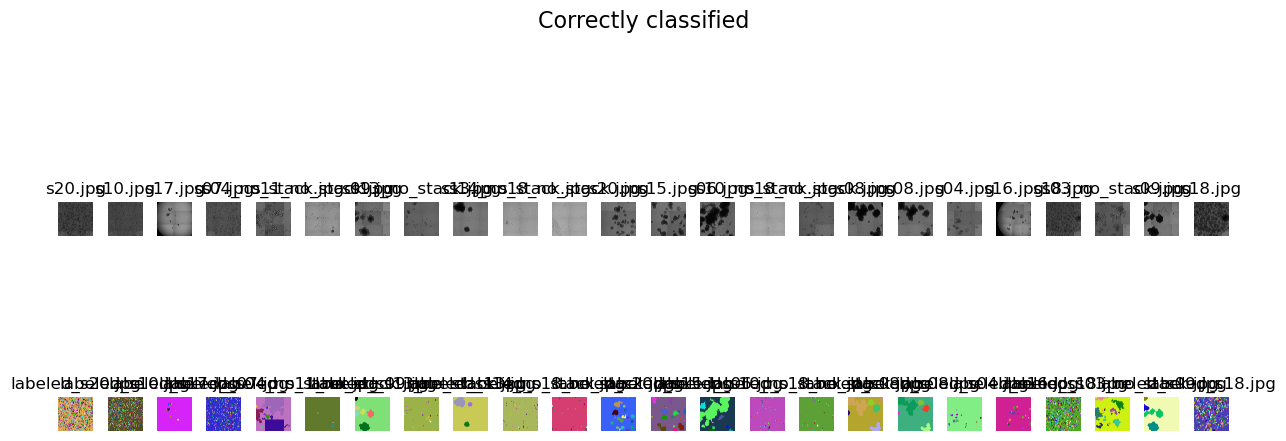

Successfully loaded data from D:/data_for_seg/


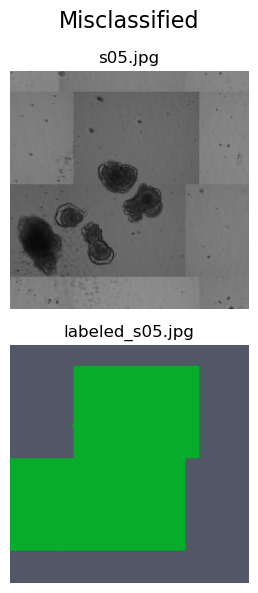

Misclassified Samples (Random State: 40):
21    keep2 - s05.jpg
dtype: object


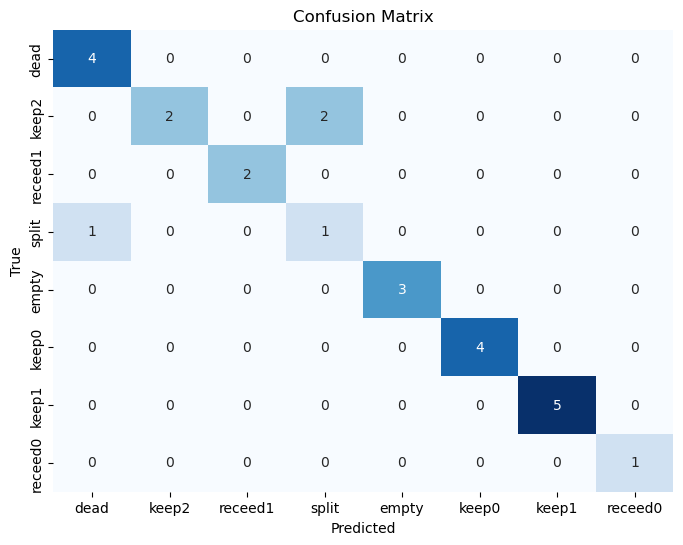

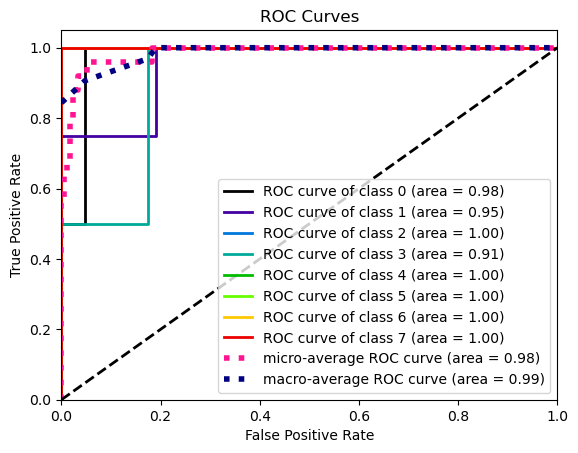

<Figure size 800x600 with 0 Axes>

[5 4 6 6 5 6 0 3 2 7 3 1 4 6 0 1 5 2 0 3 5 0 0 6 4]
Successfully loaded data from D:/data_for_seg/


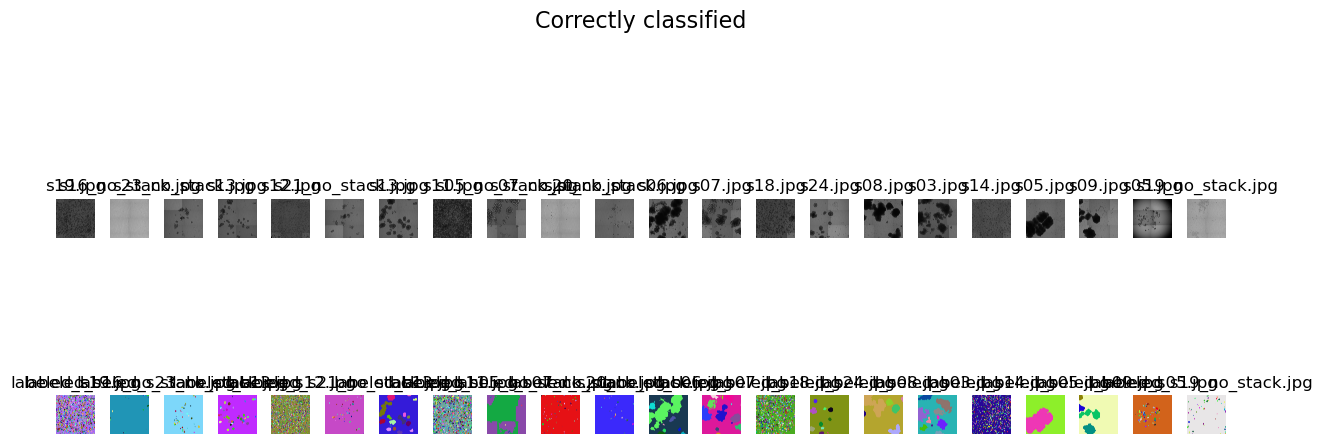

Successfully loaded data from D:/data_for_seg/


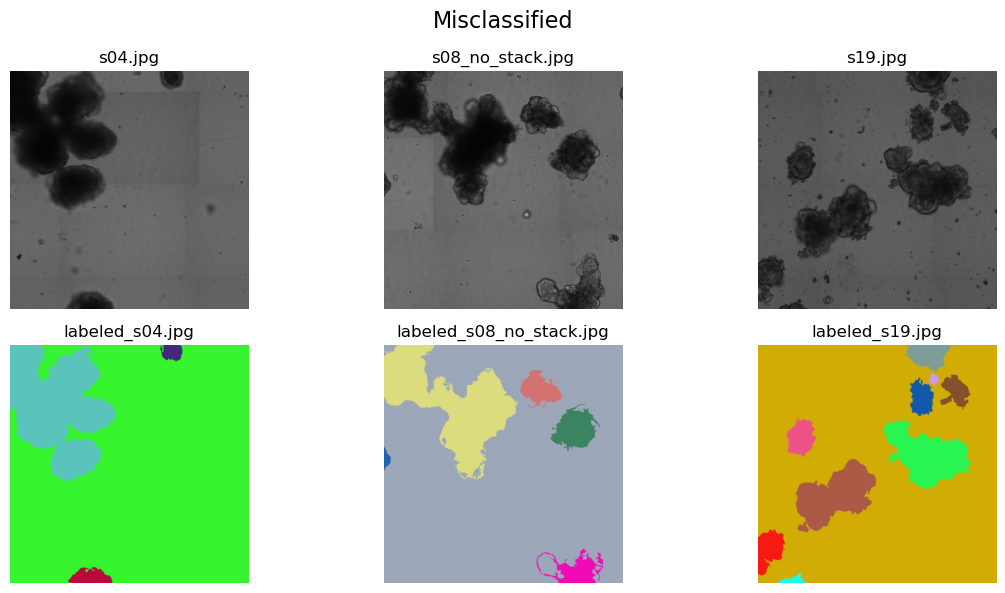

Misclassified Samples (Random State: 78):
47             split - s04.jpg
20    keep2 - s08_no_stack.jpg
35             keep2 - s19.jpg
dtype: object


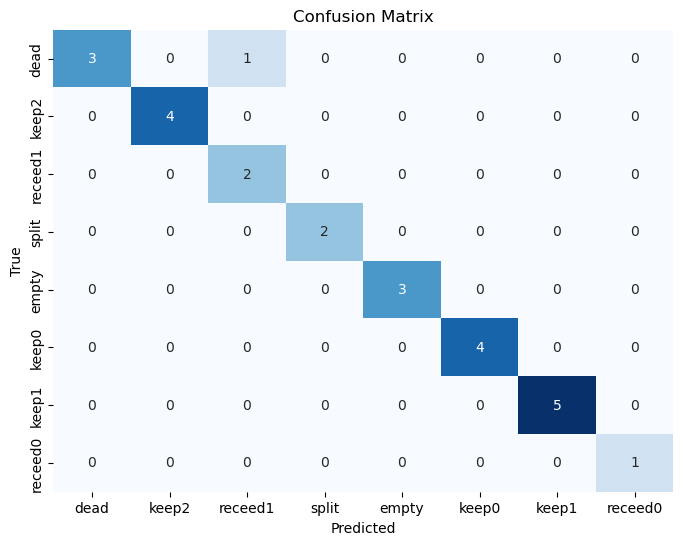

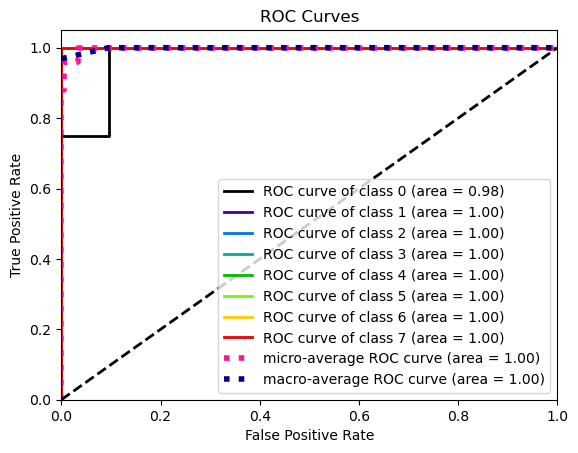

<Figure size 800x600 with 0 Axes>

[6 3 4 2 1 0 4 6 1 1 6 5 2 1 5 4 5 2 6 5 0 0 3 6 7]
Successfully loaded data from D:/data_for_seg/


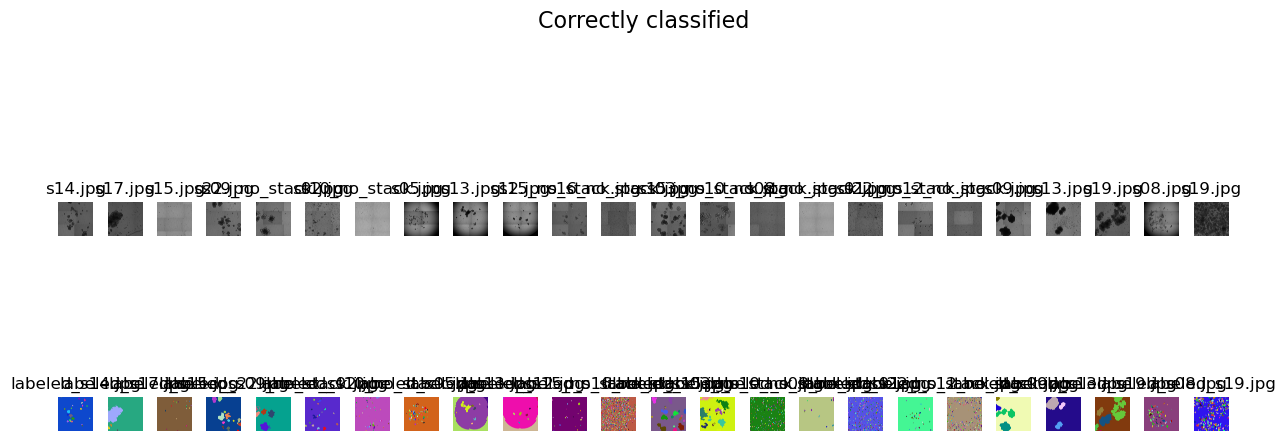

Successfully loaded data from D:/data_for_seg/


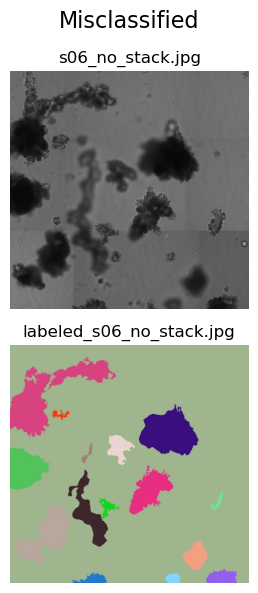

Misclassified Samples (Random State: 90):
3    dead - s06_no_stack.jpg
dtype: object


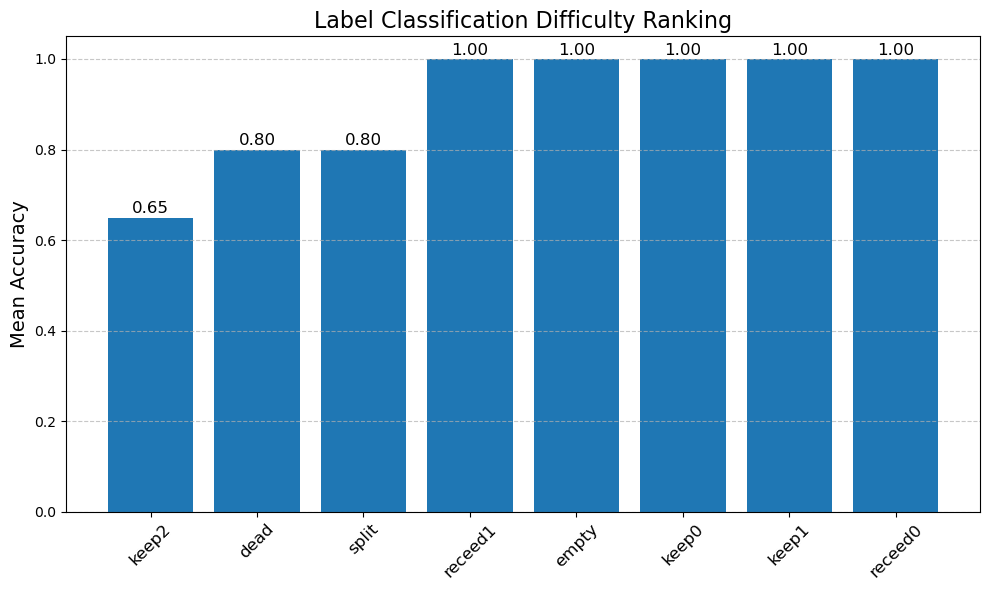

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
import scikitplot as skplt

# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path() + "statistics_features_test.csv")

# Assuming the last column is the label and the rest are features
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

# Get the number of samples per class
samples_per_class = y.value_counts()

# Print the class names along with their counts
for class_name, count in samples_per_class.items():
    print(f"Class: {class_name}, Number of samples: {count}")
# Use a list for labels to ensure consistent order
unique_labels = []
seen = set()

for item in y.values:
    if item not in seen:
        unique_labels.append(item)
        seen.add(item)
        
# Extract unique labels and create a mapping from labels to integers
unique_labels = y.unique()
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Create a new Series for y with custom labels and the original indexes
y = y.map(label_mapping)

label_metrics = {}  # Dictionary to store label-wise metrics

# Specify different random states
random_states = [30, 25, 40, 78, 90]  # Add more random states if needed

for random_state in random_states:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    # Calculate class weights to account for imbalance
    class_weights = len(y) / (len(unique_labels) * np.bincount(y))
    
    best_params = {'eval_metric': 'rmsle', 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.7, 'colsample_bytree': 0.55, 'alpha': 0, 'lambda': 1, 'seed': 0}

    # Initialize the XGBoost classifier for multiclass classification
    classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), **best_params)

    # Train the model on the entire training set
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train  # provide your own target name
    )

    # Fit the GridSearchCV instance on the training data
    classifier.fit(X_train, y_train, sample_weight=sample_weights)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a heatmap for the confusion matrix with custom labels
    plt.figure(figsize=(8, 6))
    # Specify your custom labels for both rows and columns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC curve and AUC
    y_prob = classifier.predict_proba(X_test)
    # Your code was missing the plot for ROC curve
    skplt.metrics.plot_roc(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

    # Create ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.show()

    print(y_pred)

    # Retrieve the names of the misclassified samples
    wellclassified_indices = np.where(y_test == y_pred)[0]
    wellclassified_samples = data.iloc[y_test.index[wellclassified_indices], 1] + ' - ' + data.iloc[y_test.index[wellclassified_indices], 0]
    show_samples(get_hard_disk_path(), samples=wellclassified_samples, title="Correctly classified")

    misclassified_indices = np.where(y_test != y_pred)[0]
    misclassified_samples = misclassified_samples = data.iloc[y_test.index[misclassified_indices], 1] + ' - ' + data.iloc[y_test.index[misclassified_indices], 0]
    show_samples(get_hard_disk_path(), samples=misclassified_samples, title="Misclassified")
    
    # Print the names of misclassified samples
    print("Misclassified Samples (Random State: {}):".format(random_state))
    print(misclassified_samples)
    
    misclassified_labels = {}
    wellclassified_labels = {}
    for sample in data.iloc[y_test.index[misclassified_indices], 1]:
        if sample in misclassified_labels:
            misclassified_labels[sample] += 1
        else:
            misclassified_labels[sample] = 1

    for sample in data.iloc[y_test.index[wellclassified_indices], 1]:
        if sample in wellclassified_labels:
            wellclassified_labels[sample] += 1
        else:
            wellclassified_labels[sample] = 1

    labels_accuracy = {}
    for label in unique_labels:
        wellclassified_count = wellclassified_labels.get(label, 0)
        misclassified_count = misclassified_labels.get(label, 0)

        if wellclassified_count + misclassified_count > 0:
            accuracy = wellclassified_count / (wellclassified_count + misclassified_count)
            labels_accuracy[label] = accuracy
        else:
            # Handle the case where there are no samples for a label
            labels_accuracy[label] = 0.0
    
    # Store label-wise metrics for this run
    label_metrics[random_state] = labels_accuracy
    
# Calculate the mean accuracy for each label across runs
mean_accuracies = {label: np.mean([metrics[label] for metrics in label_metrics.values()]) for label in unique_labels}

# Rank labels from easiest to hardest
ranked_labels = sorted(mean_accuracies, key=mean_accuracies.get)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = ax.bar(range(len(ranked_labels)), [mean_accuracies[label] for label in ranked_labels])

# Set x-axis labels
ax.set_xticks(range(len(ranked_labels)))
ax.set_xticklabels(ranked_labels, rotation=45, fontsize=12)

# Set y-axis label
ax.set_ylabel('Mean Accuracy', fontsize=14)

# Set title and adjust title size
ax.set_title('Label Classification Difficulty Ranking', fontsize=16)

# Customize the grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

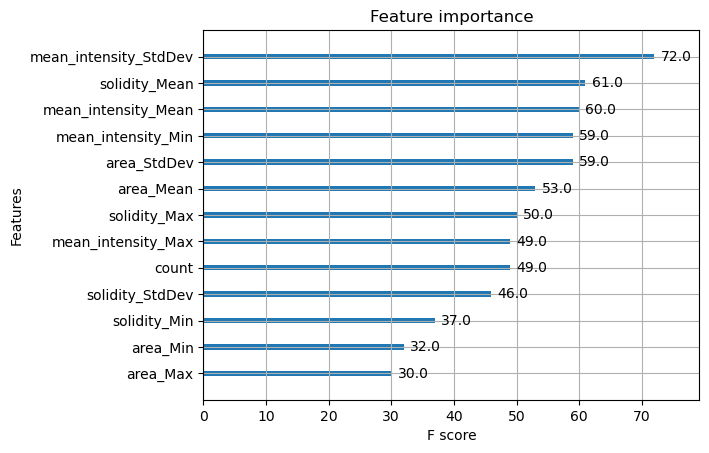

In [13]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(classifier)
plt.show()

Successfully loaded data from D:/data_for_seg/
[0]	validation_0-mlogloss:2.06014
[1]	validation_0-mlogloss:2.04179
[2]	validation_0-mlogloss:2.02169
[3]	validation_0-mlogloss:2.00307
[4]	validation_0-mlogloss:1.98422
[5]	validation_0-mlogloss:1.96540
[6]	validation_0-mlogloss:1.94846
[7]	validation_0-mlogloss:1.93057
[8]	validation_0-mlogloss:1.91195
[9]	validation_0-mlogloss:1.89570
[10]	validation_0-mlogloss:1.87936
[11]	validation_0-mlogloss:1.86213


c:\Users\Laurent\anaconda3\envs\organoids-project\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

[12]	validation_0-mlogloss:1.84638
[13]	validation_0-mlogloss:1.82847
[14]	validation_0-mlogloss:1.81203
[15]	validation_0-mlogloss:1.79626
[16]	validation_0-mlogloss:1.78055
[17]	validation_0-mlogloss:1.76504
[18]	validation_0-mlogloss:1.75020
[19]	validation_0-mlogloss:1.73425
[20]	validation_0-mlogloss:1.72075
[21]	validation_0-mlogloss:1.70708
[22]	validation_0-mlogloss:1.69243
[23]	validation_0-mlogloss:1.67839
[24]	validation_0-mlogloss:1.66466
[25]	validation_0-mlogloss:1.65135
[26]	validation_0-mlogloss:1.63866
[27]	validation_0-mlogloss:1.62510
[28]	validation_0-mlogloss:1.61224
[29]	validation_0-mlogloss:1.60055
[30]	validation_0-mlogloss:1.58795
[31]	validation_0-mlogloss:1.57609
[32]	validation_0-mlogloss:1.56362
[33]	validation_0-mlogloss:1.55177
[34]	validation_0-mlogloss:1.54066
[35]	validation_0-mlogloss:1.52858
[36]	validation_0-mlogloss:1.51717
[37]	validation_0-mlogloss:1.50557
[38]	validation_0-mlogloss:1.49351
[39]	validation_0-mlogloss:1.48189
[40]	validation_0-ml

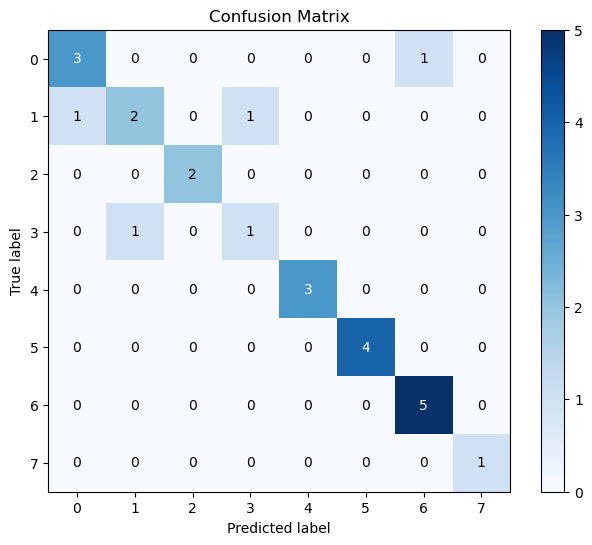

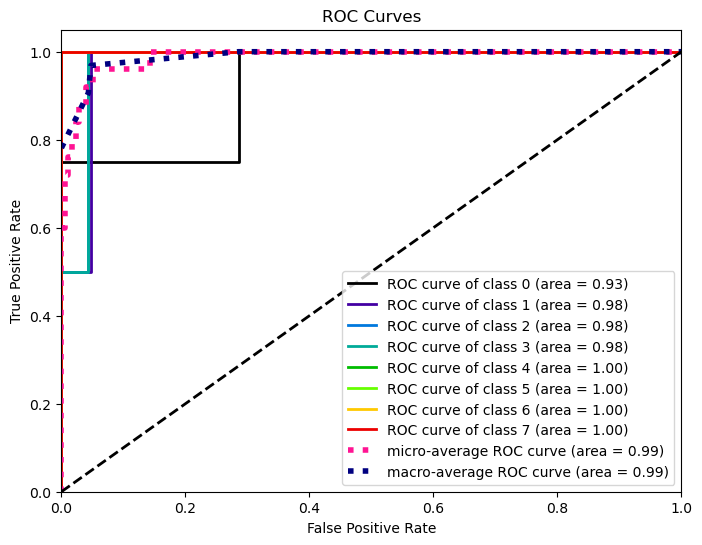

Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
[0]	validation_0-mlogloss:2.06117
[1]	validation_0-mlogloss:2.04508
[2]	validation_0-mlogloss:2.02755
[3]	validation_0-mlogloss:2.00862


c:\Users\Laurent\anaconda3\envs\organoids-project\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

[4]	validation_0-mlogloss:1.99182
[5]	validation_0-mlogloss:1.97461
[6]	validation_0-mlogloss:1.95750
[7]	validation_0-mlogloss:1.94444
[8]	validation_0-mlogloss:1.92773
[9]	validation_0-mlogloss:1.91242
[10]	validation_0-mlogloss:1.89779
[11]	validation_0-mlogloss:1.88268
[12]	validation_0-mlogloss:1.86737
[13]	validation_0-mlogloss:1.85223
[14]	validation_0-mlogloss:1.83891
[15]	validation_0-mlogloss:1.82481
[16]	validation_0-mlogloss:1.81105
[17]	validation_0-mlogloss:1.79678
[18]	validation_0-mlogloss:1.78530
[19]	validation_0-mlogloss:1.77509
[20]	validation_0-mlogloss:1.76087
[21]	validation_0-mlogloss:1.75026
[22]	validation_0-mlogloss:1.73742
[23]	validation_0-mlogloss:1.72640
[24]	validation_0-mlogloss:1.71309
[25]	validation_0-mlogloss:1.69957
[26]	validation_0-mlogloss:1.68864
[27]	validation_0-mlogloss:1.67870
[28]	validation_0-mlogloss:1.66809
[29]	validation_0-mlogloss:1.65723
[30]	validation_0-mlogloss:1.64567
[31]	validation_0-mlogloss:1.63532
[32]	validation_0-mlogloss

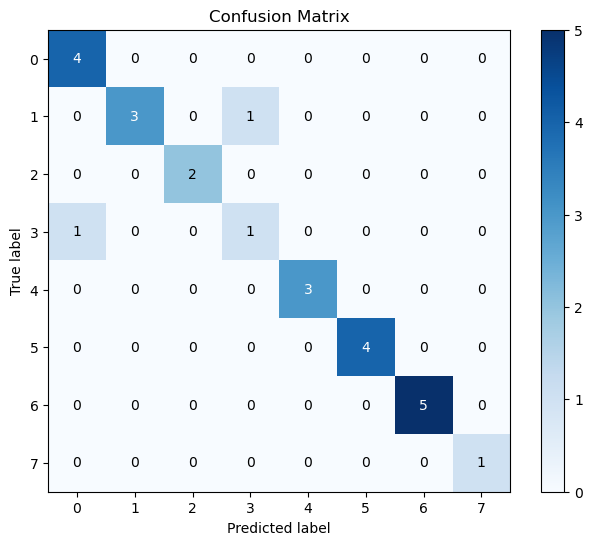

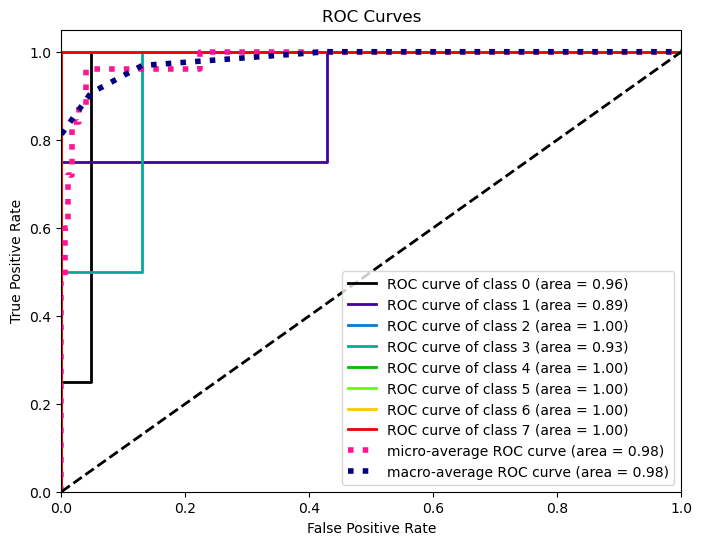

Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
[0]	validation_0-mlogloss:2.06117
[1]	validation_0-mlogloss:2.04266
[2]	validation_0-mlogloss:2.02429
[3]	validation_0-mlogloss:2.00765
[4]	validation_0-mlogloss:1.99007
[5]	validation_0-mlogloss:1.97147
[6]	validation_0-mlogloss:1.95409
[7]	validation_0-mlogloss:1.93840
[8]	validation_0-mlogloss:1.92223
[9]	validation_0-mlogloss:1.90554
[10]	validation_0-mlogloss:1.88944
[11]	validation_0-mlogloss:1.87452
[12]	validation_0-mlogloss:1.85870
[13]	validation_0-mlogloss:1.84219
[14]	validation_0-mlogloss:1.82869
[15]	validation_0-mlogloss:1.81369
[16]	validation_0-mlogloss:1.80084
[17]	validation_0-mlogloss:1.78489
[18]	validation_0-mlogloss:1.77101
[19]	validation_0-mlogloss:1.75666
[20]	validation_0-mlogloss:1.74262
[21]	validation_0-mlogloss:1.73011
[22]	validation_0-mlogloss:1.71688


c:\Users\Laurent\anaconda3\envs\organoids-project\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

[23]	validation_0-mlogloss:1.70468
[24]	validation_0-mlogloss:1.69241
[25]	validation_0-mlogloss:1.67878
[26]	validation_0-mlogloss:1.66530
[27]	validation_0-mlogloss:1.65197
[28]	validation_0-mlogloss:1.63922
[29]	validation_0-mlogloss:1.62771
[30]	validation_0-mlogloss:1.61672
[31]	validation_0-mlogloss:1.60469
[32]	validation_0-mlogloss:1.59122
[33]	validation_0-mlogloss:1.58182
[34]	validation_0-mlogloss:1.57088
[35]	validation_0-mlogloss:1.56043
[36]	validation_0-mlogloss:1.54847
[37]	validation_0-mlogloss:1.53625
[38]	validation_0-mlogloss:1.52475
[39]	validation_0-mlogloss:1.51446
[40]	validation_0-mlogloss:1.50520
[41]	validation_0-mlogloss:1.49482
[42]	validation_0-mlogloss:1.48420
[43]	validation_0-mlogloss:1.47481
[44]	validation_0-mlogloss:1.46517
[45]	validation_0-mlogloss:1.45516
[46]	validation_0-mlogloss:1.44529
[47]	validation_0-mlogloss:1.43645
[48]	validation_0-mlogloss:1.42730
[49]	validation_0-mlogloss:1.41776
[50]	validation_0-mlogloss:1.40837
[51]	validation_0-ml

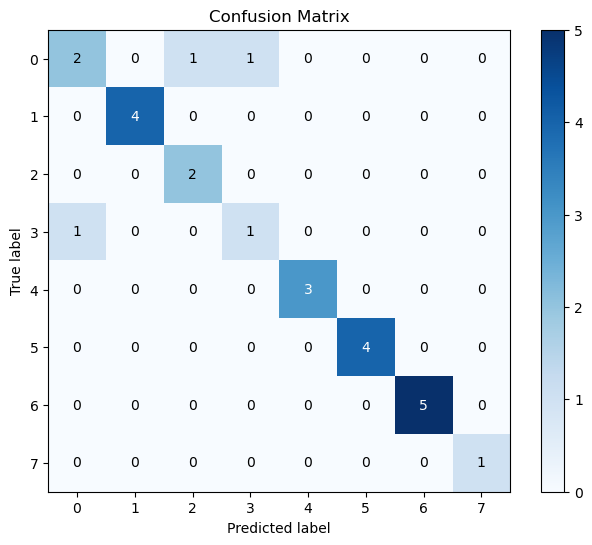

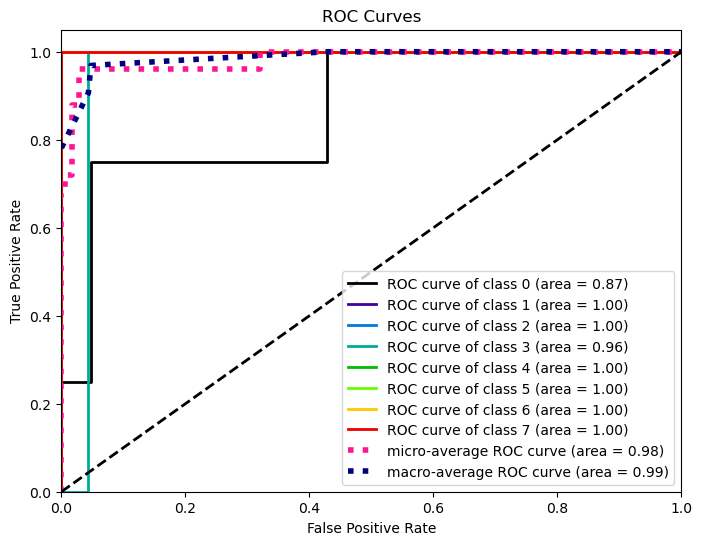

Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
import scikitplot as skplt

# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path()+"statistics_features_test.csv")
# Assuming the last column is the label and the rest are features
X = data.iloc[:, 2:]
y = data.iloc[:, 1]
# Use a list for labels to ensure consistent order
unique_labels = []
seen = set()

for item in y.values:
    if item not in seen:
        unique_labels.append(item)
        seen.add(item)
        
# Extract unique labels and create a mapping from labels to integers
unique_labels = y.unique()
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Create a new Series for y with custom labels and the original indexes
y = y.map(label_mapping)

# Specify different random states
random_states = [1, 2, 3]  # Add more random states if needed

for random_state in random_states:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    # Calculate class weights to account for imbalance
    class_weights = len(y) / (len(unique_labels) * np.bincount(y))

    # Initialize the XGBoost classifier for multiclass classification
    classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), verbose=False)

    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2, 0.4],
        'n_estimators': [100, 200, 300, 500, 1000],
        'max_depth': [3, 4, 5, 7, 10],
        'subsample': [0.8, 0.9, 1.0],
    }

    # Create a GridSearchCV instance
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,  # You can adjust the number of cross-validation folds
        n_jobs=-1  # Use all available CPU cores
    )

    # Train the model on the entire training set
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train  # provide your own target name
    )

    # Fit the GridSearchCV instance on the training data
    grid_search.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_test, y_test)])

    
    eval_auc = roc_auc_score( y_test, grid_search.best_estimator_.predict_proba(X_test), multi_class='ovr')
    
    # Assuming you have already trained the best model using grid_search

    # Plot the confusion matrix
    y_pred = grid_search.best_estimator_.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(8, 6), title="Confusion Matrix")

    # Plot ROC curves and calculate AUC
    y_probas = grid_search.best_estimator_.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas, figsize=(8, 6), title="ROC Curves")

    # Display the plots
    plt.show()
    
    best_params = grid_search.best_params_
    print("Best Hyperparameters:")
    print(best_params)
    
    



Successfully loaded data from D:/data_for_seg/


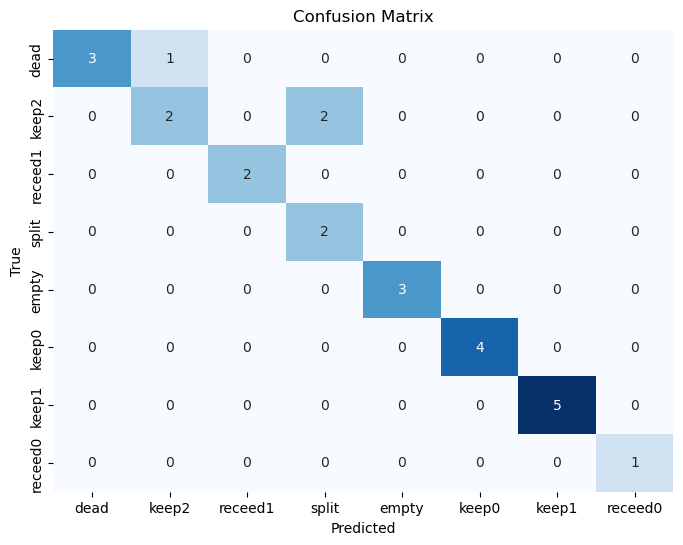

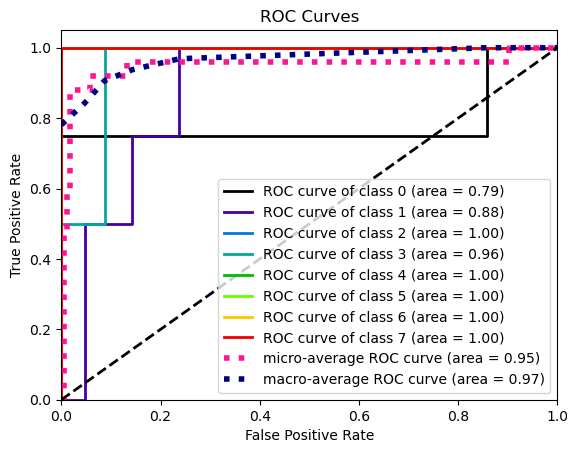

<Figure size 800x600 with 0 Axes>

[1 0 0 0 3 1 1 3 2 2 3 3 4 4 4 5 5 5 5 6 6 6 6 6 7]
Successfully loaded data from D:/data_for_seg/


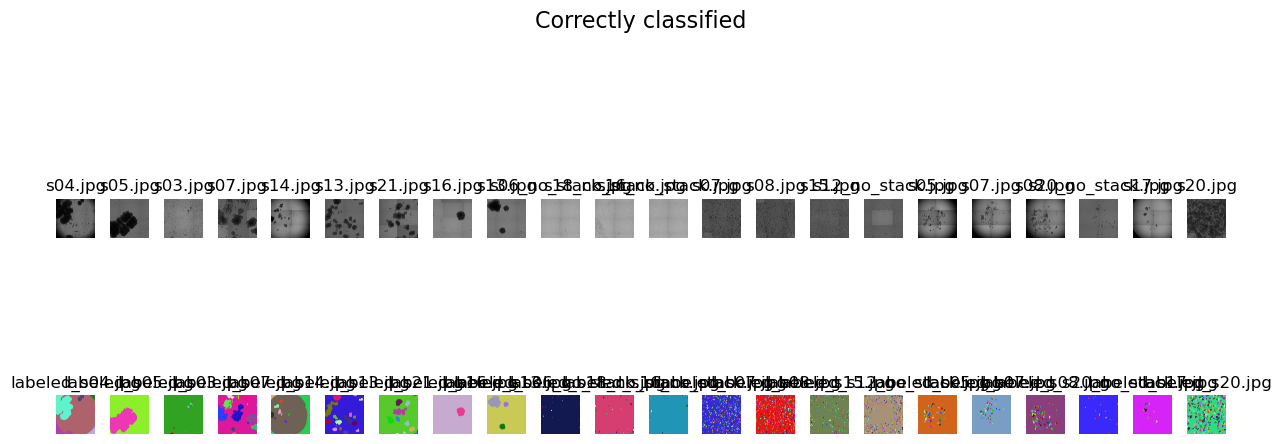

Successfully loaded data from D:/data_for_seg/


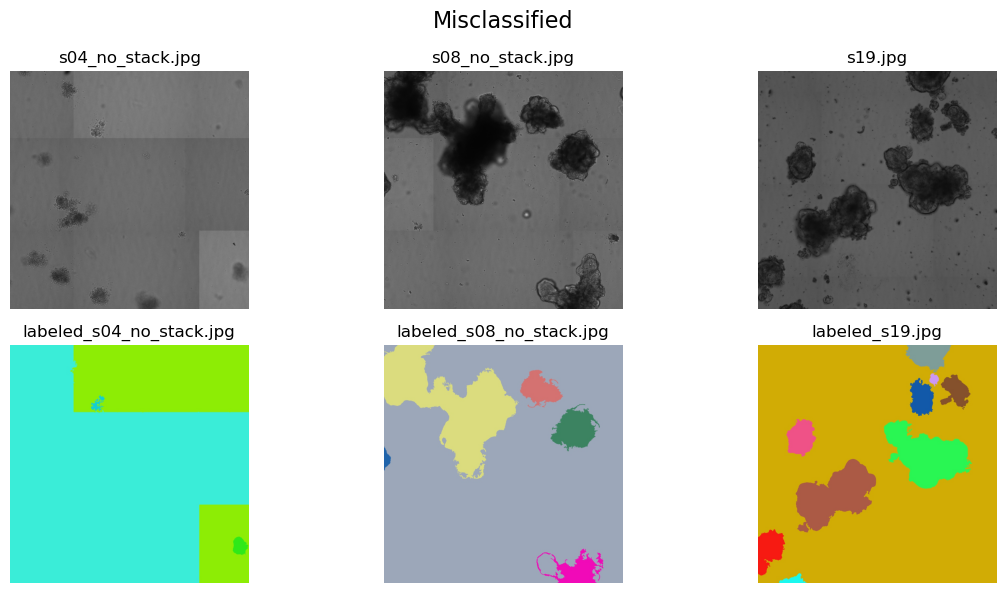

Misclassified Samples (Random State: 42):
0      dead - s04_no_stack.jpg
20    keep2 - s08_no_stack.jpg
35             keep2 - s19.jpg
dtype: object


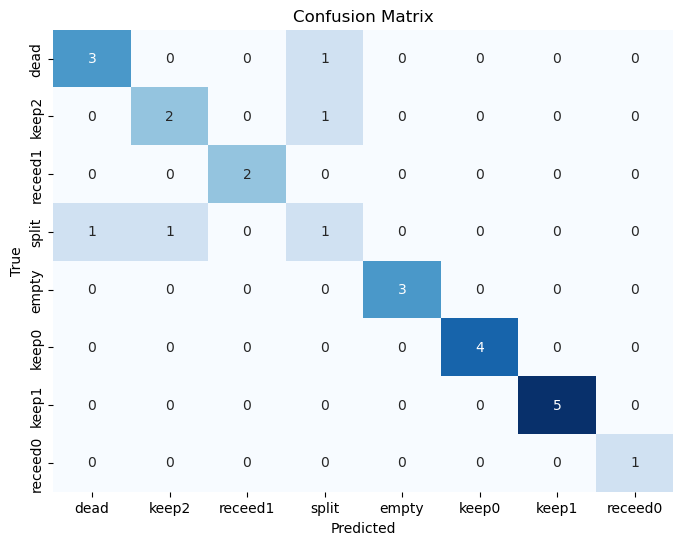

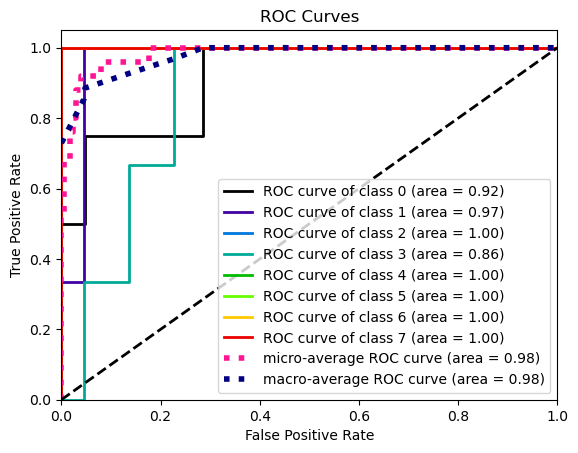

<Figure size 800x600 with 0 Axes>

[0 0 0 3 3 1 1 2 2 3 0 1 4 4 4 5 5 5 5 6 6 6 6 6 7]
Successfully loaded data from D:/data_for_seg/


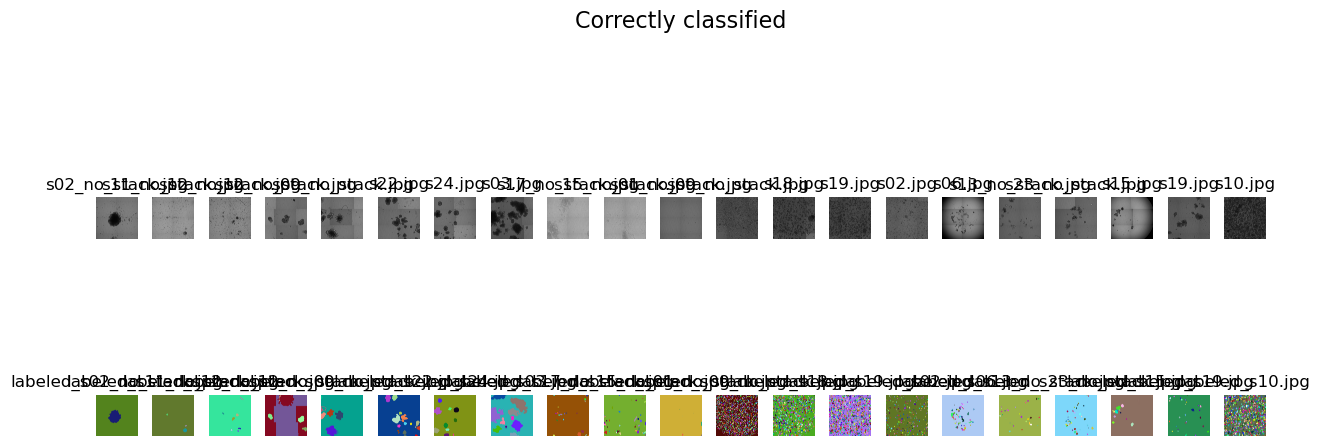

Successfully loaded data from D:/data_for_seg/


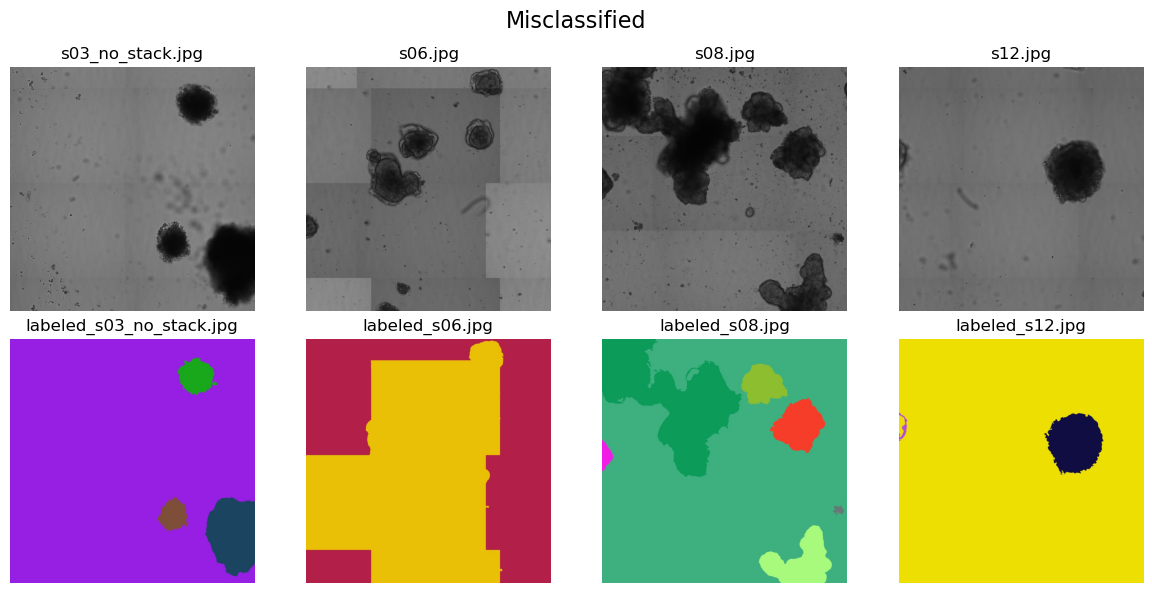

Misclassified Samples (Random State: 42):
16    dead - s03_no_stack.jpg
22            keep2 - s06.jpg
49            split - s08.jpg
54            split - s12.jpg
dtype: object


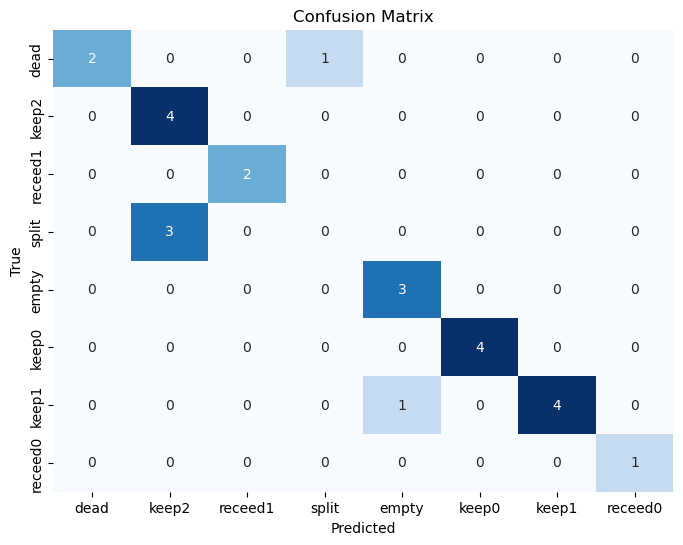

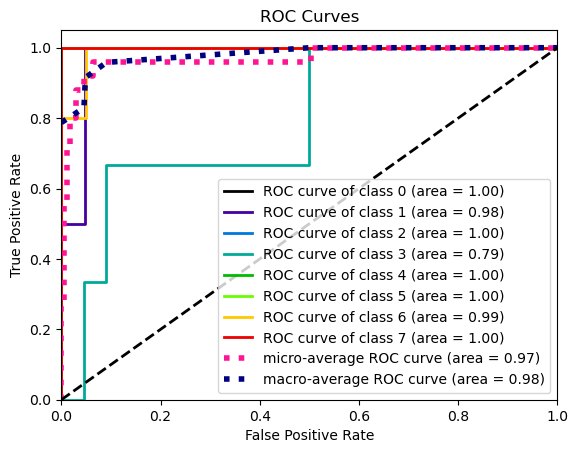

<Figure size 800x600 with 0 Axes>

[0 3 0 1 1 1 1 2 2 1 1 1 4 4 4 5 5 5 5 6 6 4 6 6 7]
Successfully loaded data from D:/data_for_seg/


Successfully loaded data from D:/data_for_seg/


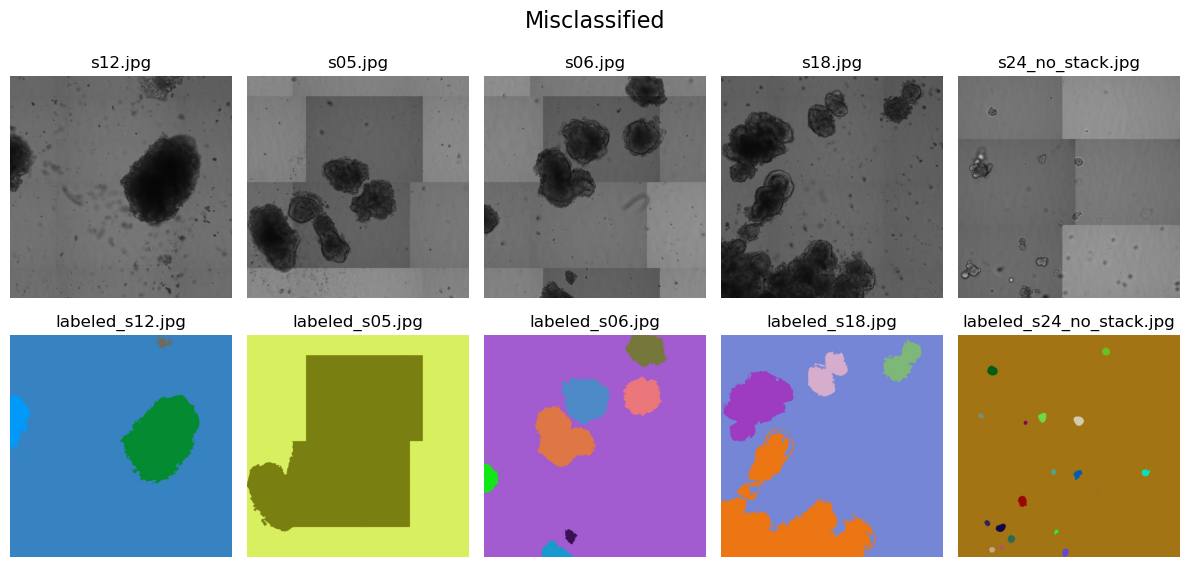

Misclassified Samples (Random State: 42):
9                dead - s12.jpg
48              split - s05.jpg
51              split - s06.jpg
56              split - s18.jpg
109    keep1 - s24_no_stack.jpg
dtype: object


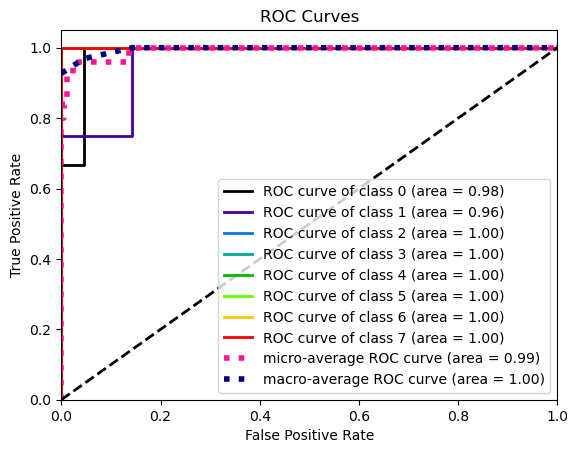

<Figure size 800x600 with 0 Axes>

[0 0 0 2 1 1 1 2 2 0 3 4 4 4 5 5 5 5 5 6 6 6 6 7 7]
Successfully loaded data from D:/data_for_seg/


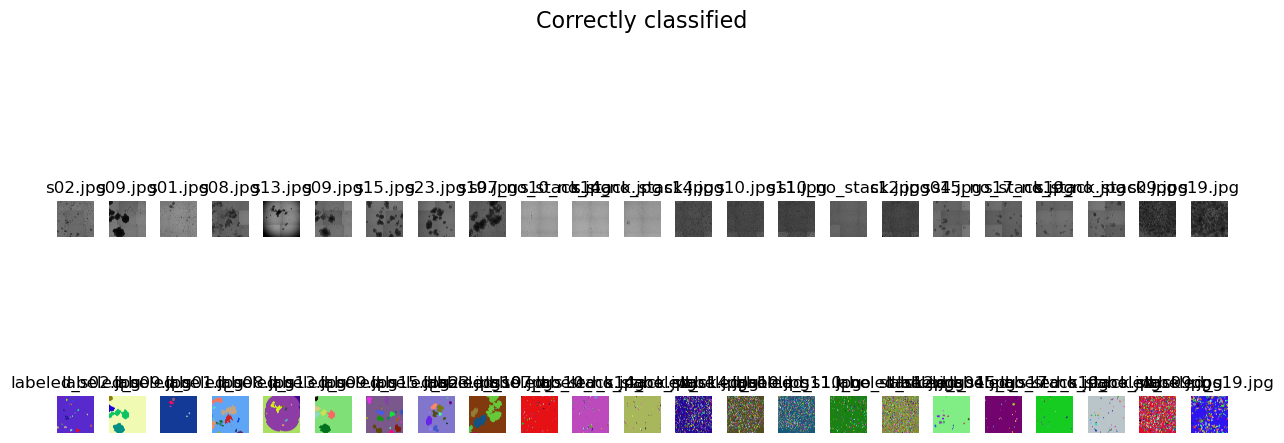

Successfully loaded data from D:/data_for_seg/


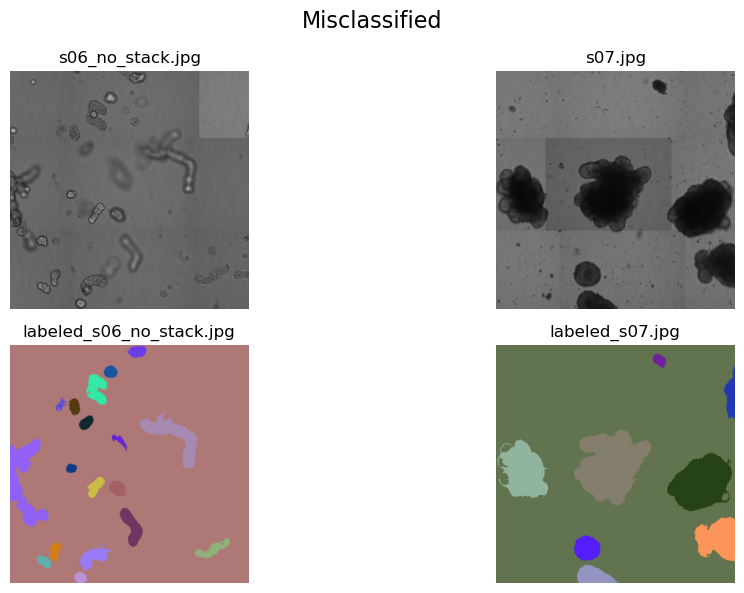

Misclassified Samples (Random State: 42):
18    keep2 - s06_no_stack.jpg
50             split - s07.jpg
dtype: object


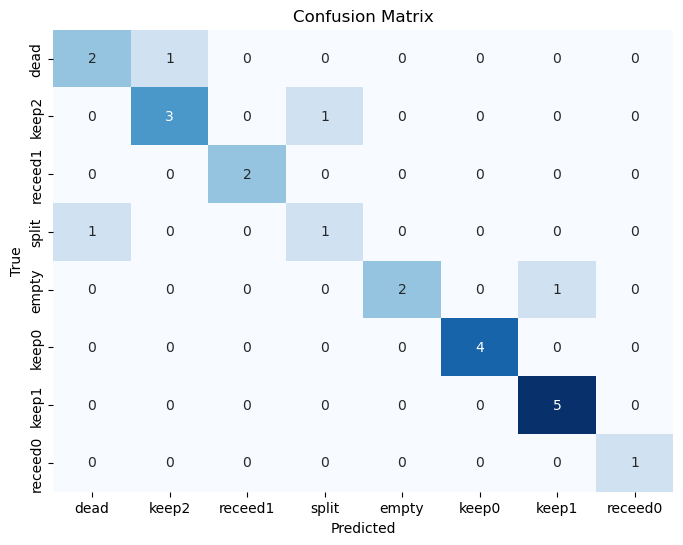

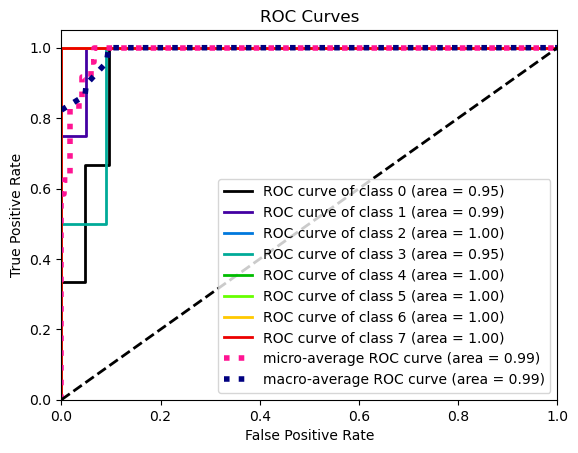

<Figure size 800x600 with 0 Axes>

[1 0 0 3 1 1 1 2 2 0 3 4 4 6 5 5 5 5 6 6 6 6 6 7]
Successfully loaded data from D:/data_for_seg/


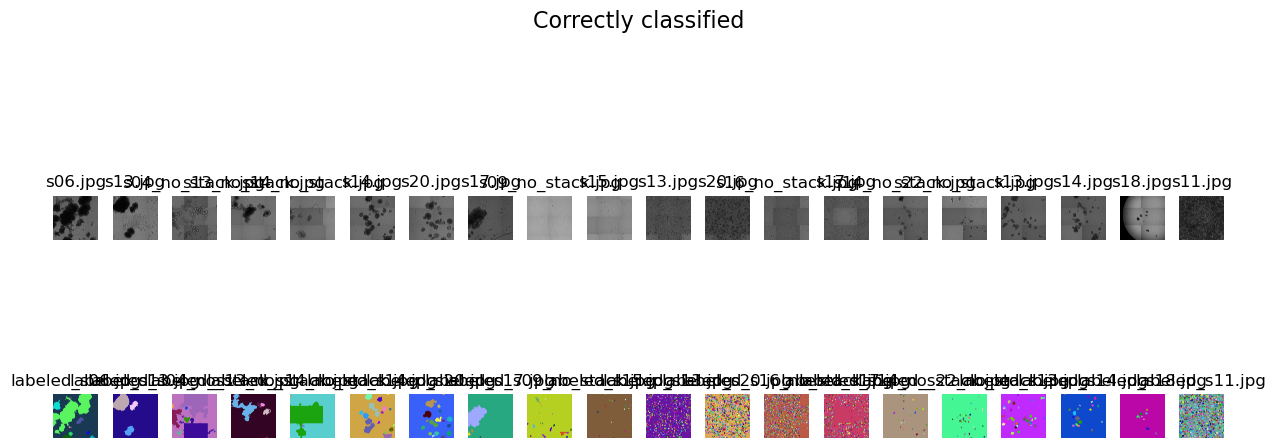

Successfully loaded data from D:/data_for_seg/


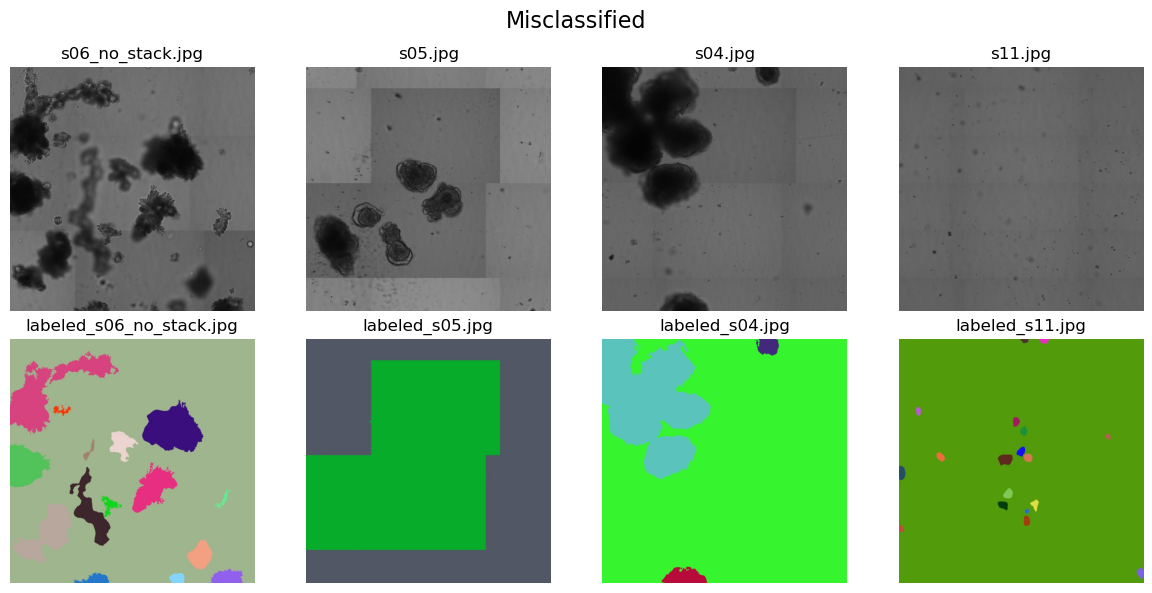

Misclassified Samples (Random State: 42):
3     dead - s06_no_stack.jpg
21            keep2 - s05.jpg
47            split - s04.jpg
63            empty - s11.jpg
dtype: object


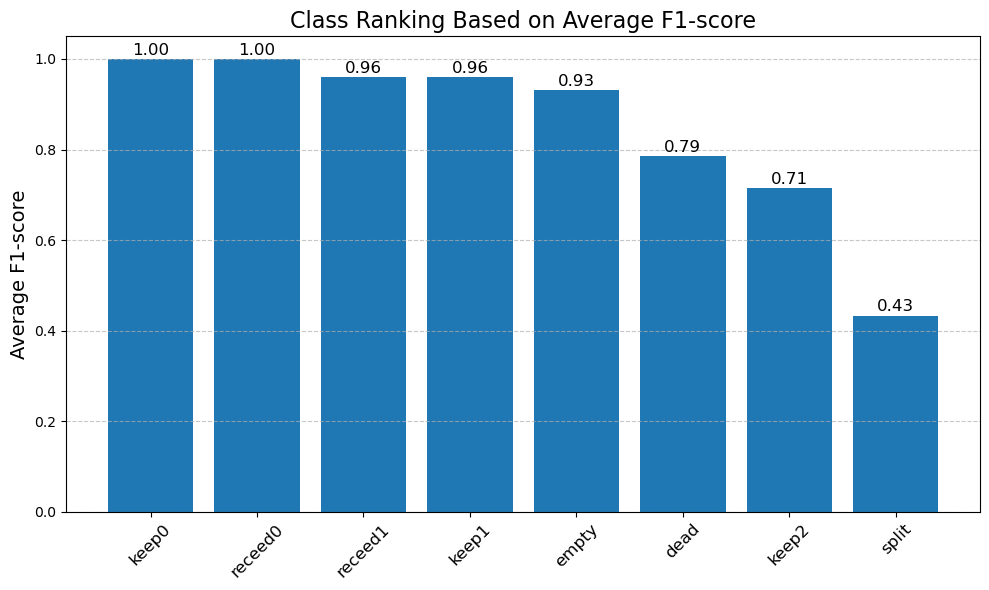

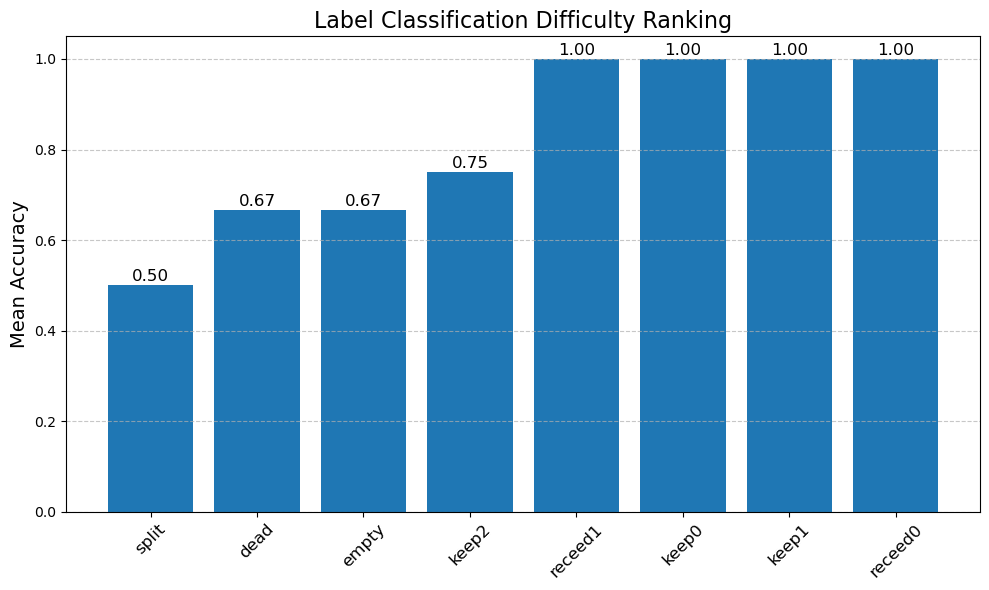

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
import scikitplot as skplt
from sklearn.metrics import f1_score

random_state = 42

# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path() + "statistics_features_test.csv")

# Assuming the last column is the label and the rest are features
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

unique_labels = y.unique()
        
# Encode labels
label_mapping = {label: i for i, label in enumerate(unique_labels)}
y = y.map(label_mapping)

label_metrics = {}  # Dictionary to store label-wise metrics

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)  # Here, 5 is the number of splits/folds

# List to store results for each fold
fold_results = []
# Dictionary to store cumulative F1-scores for each class
cumulative_f1_scores = {label: 0 for label in unique_labels}

# Loop through each fold
for train_index, test_index in kf.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Calculate class weights to account for imbalance
    class_weights = len(y) / (len(unique_labels) * np.bincount(y))

    best_params = {'eval_metric': 'rmsle', 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.7, 'colsample_bytree': 0.55, 'alpha': 0, 'lambda': 1, 'seed': 0}

    # Initialize the XGBoost classifier for multiclass classification
    classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), **best_params)

    # Train the model on the entire training set
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train  # provide your own target name
    )

    # Fit the GridSearchCV instance on the training data
    classifier.fit(X_train, y_train, sample_weight=sample_weights)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    fold_results.append({
        'y_test': y_test,
        'y_pred': y_pred,
        # ... any other metrics or results you want to store
    })

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a heatmap for the confusion matrix with custom labels
    plt.figure(figsize=(8, 6))
    # Specify your custom labels for both rows and columns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC curve and AUC
    y_prob = classifier.predict_proba(X_test)
    
    # Calculate F1-score for each class
    f1_scores_per_class = f1_score(y_test, y_pred, average=None)

    for idx, label in enumerate(unique_labels):
        cumulative_f1_scores[label] += f1_scores_per_class[idx]

    # Your code was missing the plot for ROC curve
    skplt.metrics.plot_roc(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

    # Create ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.show()

    print(y_pred)

    # Retrieve the names of the misclassified samples
    wellclassified_indices = np.where(y_test == y_pred)[0]
    wellclassified_samples = data.iloc[y_test.index[wellclassified_indices], 1] + ' - ' + data.iloc[y_test.index[wellclassified_indices], 0]
    show_samples(get_hard_disk_path(), samples=wellclassified_samples, title="Correctly classified")

    misclassified_indices = np.where(y_test != y_pred)[0]
    misclassified_samples = misclassified_samples = data.iloc[y_test.index[misclassified_indices], 1] + ' - ' + data.iloc[y_test.index[misclassified_indices], 0]
    show_samples(get_hard_disk_path(), samples=misclassified_samples, title="Misclassified")

    # Print the names of misclassified samples
    print("Misclassified Samples (Random State: {}):".format(random_state))
    print(misclassified_samples)

    misclassified_labels = {}
    wellclassified_labels = {}
    for sample in data.iloc[y_test.index[misclassified_indices], 1]:
        if sample in misclassified_labels:
            misclassified_labels[sample] += 1
        else:
            misclassified_labels[sample] = 1

    for sample in data.iloc[y_test.index[wellclassified_indices], 1]:
        if sample in wellclassified_labels:
            wellclassified_labels[sample] += 1
        else:
            wellclassified_labels[sample] = 1

    labels_accuracy = {}
    for label in unique_labels:
        wellclassified_count = wellclassified_labels.get(label, 0)
        misclassified_count = misclassified_labels.get(label, 0)

        if wellclassified_count + misclassified_count > 0:
            accuracy = wellclassified_count / (wellclassified_count + misclassified_count)
            labels_accuracy[label] = accuracy
        else:
            # Handle the case where there are no samples for a label
            labels_accuracy[label] = 0.0

# Calculate average F1-score for each class
average_f1_scores = {label: score/5 for label, score in cumulative_f1_scores.items()} # Assuming 5 folds

# Rank labels based on average F1-score
ranked_labels = sorted(average_f1_scores, key=average_f1_scores.get, reverse=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = ax.bar(range(len(ranked_labels)), [average_f1_scores[label] for label in ranked_labels])

# Set x-axis labels
ax.set_xticks(range(len(ranked_labels)))
ax.set_xticklabels(ranked_labels, rotation=45, fontsize=12)

# Set y-axis label
ax.set_ylabel('Average F1-score', fontsize=14)

# Set title and adjust title size
ax.set_title('Class Ranking Based on Average F1-score', fontsize=16)

# Customize the grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Store label-wise metrics for this run
label_metrics[random_state] = labels_accuracy
    
# Calculate the mean accuracy for each label across runs
mean_accuracies = {label: np.mean([metrics[label] for metrics in label_metrics.values()]) for label in unique_labels}

# Rank labels from easiest to hardest
ranked_labels = sorted(mean_accuracies, key=mean_accuracies.get)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = ax.bar(range(len(ranked_labels)), [mean_accuracies[label] for label in ranked_labels])

# Set x-axis labels
ax.set_xticks(range(len(ranked_labels)))
ax.set_xticklabels(ranked_labels, rotation=45, fontsize=12)

# Set y-axis label
ax.set_ylabel('Mean Accuracy', fontsize=14)

# Set title and adjust title size
ax.set_title('Label Classification Difficulty Ranking', fontsize=16)

# Customize the grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Successfully loaded data from E:/data_for_seg/


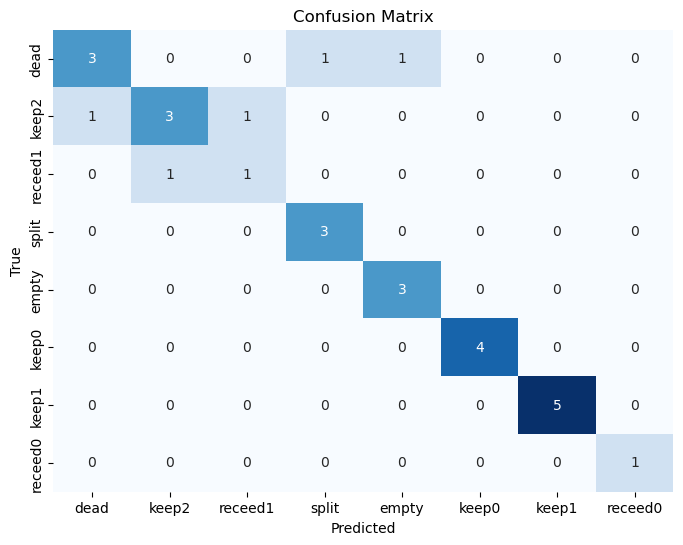

[11:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


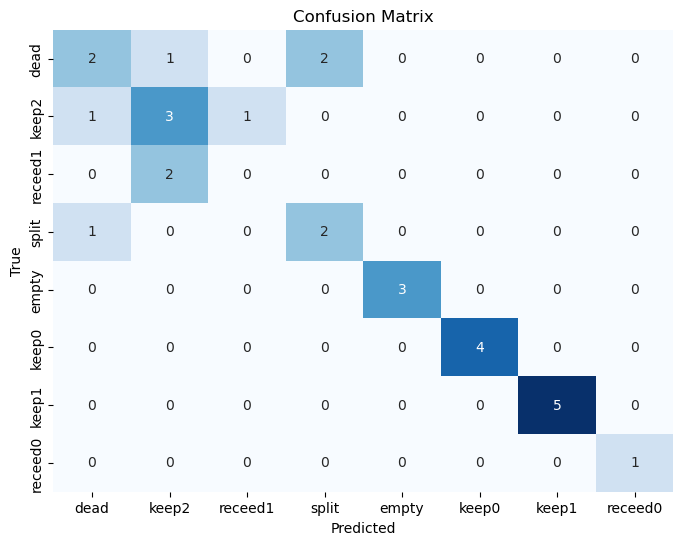

[11:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


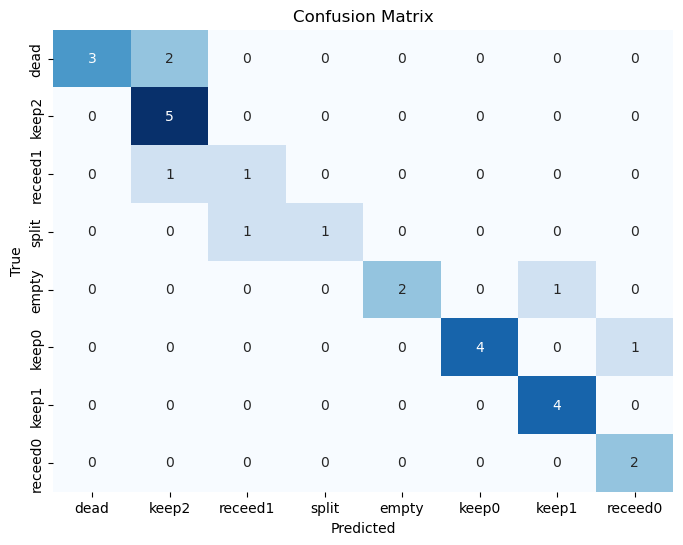

[11:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


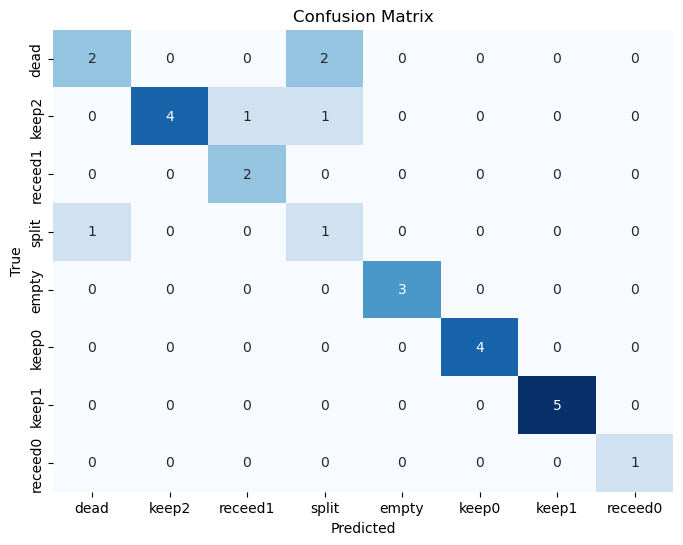

[11:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[11:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
The figure layout has changed to tight


In [12]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import shap
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

random_state = 42

X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path("Segmentation"))
#visualize_correlation(X)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
ix_training, ix_test = [], []
# Loop through each fold and append the training & test indices to the empty lists above
for fold in kf.split(X, y):
    ix_training.append(fold[0]), ix_test.append(fold[1])
# List to store averaged SHAP values for each fold
average_shap_values_per_fold = []
cumulative_f1_scores = {label: 0 for label in unique_labels}

for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): #-#-#
    X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
    y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]
    classifier = train_model(X_train, y_train, unique_labels, "Xgboost")
    y_pred = classifier.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, unique_labels)
    wellclassified_samples, misclassified_samples = get_classification_details(y_test, y_pred, data)
    #show_samples(get_hard_disk_path(), samples=wellclassified_samples, title="Correctly classified")
    #show_samples(get_hard_disk_path(), samples=misclassified_samples, title="Misclassified")
    shap_values = get_shap(classifier, X_test)
    # Now, you can plot the beeswarm chart
    # Check if SHAP values are a list (multi-class scenario)
    if isinstance(shap_values, list):
        # Summing SHAP values across all classes
        shap_values = np.sum([np.abs(sv) for sv in shap_values], axis=0)

    # Averaging SHAP values across samples for this fold
    average_shap_values_this_fold = np.mean(shap_values, axis=0)
    average_shap_values_per_fold.append(average_shap_values_this_fold)

    f1_scores_per_class = f1_score(y_test, y_pred, average=None)
    for idx, label in enumerate(unique_labels):
        cumulative_f1_scores[label] += f1_scores_per_class[idx]

# Averaging SHAP values across all folds
average_shap_values = np.mean(average_shap_values_per_fold, axis=0)

# Ensuring correct format for summary_plot
average_shap_values_2d = average_shap_values.reshape(1, -1)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
shap.summary_plot(average_shap_values_2d, features=X.columns, plot_type="bar", show=False)
plt.tight_layout()
plt.show()
average_f1_scores = {label: score/5 for label, score in cumulative_f1_scores.items()} 
ranked_labels = sorted(average_f1_scores, key=average_f1_scores.get, reverse=True)
plot_average_f1_scores(ranked_labels, average_f1_scores)
plot_features_importance(classifier)

In [7]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import uniform, randint
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import shap
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Assuming df is your DataFrame
X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter distributions
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'colsample_bytree': uniform(0.3, 0.7),
}

# Create the base model to tune
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the scorer, choosing an averaging method suitable for your problem
f1_scorer = make_scorer(f1_score, average='weighted')  # or 'macro', 'micro'

# Configure RandomizedSearchCV with F1-score as the scoring metric
random_search = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist, 
    n_iter=200, cv=10, verbose=2, random_state=42, n_jobs=-1,
    scoring=f1_scorer  # Use the F1-score for evaluation
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding F1-score
print("Best parameters found: ", random_search.best_params_)
print("Best F1-score: ", random_search.best_score_)

# Predict on the test set with the best found parameters
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the best model's F1-score on the test set
test_f1_score = f1_score(y_test, predictions, average='weighted')  # Use 'weighted' to account for label imbalance
print("Test F1-score: ", test_f1_score)

Successfully loaded data from E:/data_for_seg/
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


The least populated class in y has only 5 members, which is less than n_splits=10.


Best parameters found:  {'colsample_bytree': 0.3064379361316407, 'learning_rate': 0.030294308573206426, 'max_depth': 5, 'n_estimators': 252}
Best F1-score:  0.7991341991341991
Test F1-score:  0.7891929499072357


In [9]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import uniform, randint
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import shap
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgbtune import tune_xgb_model

# Assuming df is your DataFrame
X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params, round_count = tune_xgb_model(params, X_train, y_train)



Successfully loaded data from E:/data_for_seg/
tuning pass 0...
computing best round...
best round: 43
tuning max_depth and min_child_weight ...
best loss: 0.0003
best max_depth: 5
best min_child_weight: 1
tuning gamma ...
best loss: 0.0003
best gamma: 0.0
re-computing best round...
best round: 43
tuning subsample and colsample_bytree ...
best loss: 0.0003
best subsample: 1.0
best colsample_bytree: 0.8
fine tuning subsample and colsample_bytree ...
best loss: 0.0003
best subsample: 1.0
best colsample_bytree: 0.8
tuning alpha and lambda ...
best loss: 0.0003
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.0003
best seed: 0
{'eval_metric': 'rmsle', 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 0.8, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 73
tuning max_depth and min_child_weight ...
best loss: 0.0002
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.0002
best gamm